In [86]:
from space.planets import venus
from orbit.pointing import simulation
from orbit.geometry import getTiming
from orbit.envision import loadSV
from measurement.measurement import state_vector

""" System Packages """
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
from datetime import datetime as dt
import os

In [87]:
sim_folder = os.path.join(r"C:\Users",
                          r"ishuwa.sikaneta",
                          r"OneDrive - ESA",
                          r"Documents",
                          r"ESTEC",
                          r"Envision",
                          r"PointingSimulations")

### Load ESOC-supplied orbit file

In [88]:
sv = loadSV()

# Simulate Pointing Errors

The following class simulates pointing errors for an Envision-type SAR

In [89]:
eSim = simulation(planet = venus(),
                  e_ang = 14.28, # The effective angle of the beam relative to spacecraft coordinate frame
                  azAxis = 5.5,  # The length of the reflector in the azimuth direction. Leads to 0.99 degrees
                  elAxis = 0.6125,  # The length of the reflector in the elevation direction. Leads to 8.9 degrees
                  carrier = 3.15e9)

### Select a subset of state vectors

Select a range of state vectors to use for error simulation

In [90]:
selection_range = [270, 44480, 2]
mysvs = eSim.state(sv.measurementData, selection_range)
 
times = [(sv.measurementTime[k] - sv.measurementTime[0])/np.timedelta64(1, 's') 
         for k in range(*selection_range)]

### Test the simulation of errors

Test right looking configuration with an off-nadir angle of -18.7 and left looking with an off-nadir of 18.7. The off-nadir angle of 18.7 corresponds to a 20 degree incidence angle. An off-nadir angle of 37.6 degrees corresponds to an incidence angle of 40 degrees.

In [91]:
off_nadir = -37.6

### Define Covariances

Define the set of input covariance matrices for the simulation. These have been determined from the pointing justification document (ESA) and the JPL-provided pointing spreadsheet.

Norm of u: 1.000000
u*e1: 0.000000
u*e2: 0.792262, v: 0.792290
uP*VP: 0.000000
Roll: -51.8783, Pitch: 0.0087, Yaw: -0.0068
Percent of Doppler centroids in violation: 3.3154


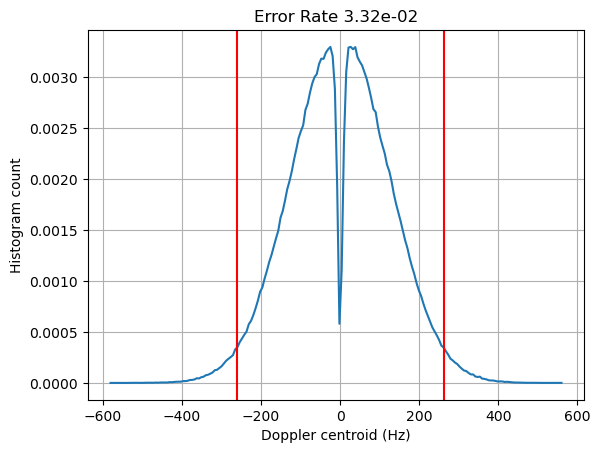

Percent of Swaths in violation: 4.2561


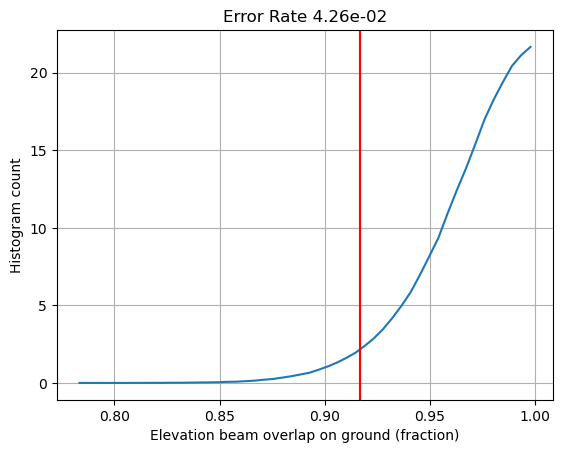

In [92]:
X = mysvs[np.random.randint(0,len(mysvs))]
""" Define a margin for covariances in terms of RollPitchYaw """
margin = np.diag([(11.5e-3/2)**2, (0.2e-3/2)**2, (0.2e-3/2)**2])

""" Define the covariances for Thales Alenia Space data """  
covariancesESOCTwoDay = {
    "description": "Covariance matrix errors for TAS consortium",
    "spacecraft": {
        "description": """Errors in the orienting the spacecraft. 
                          These in include star-tracker error, TED, actuator error, 
                          e.t.c.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([1.95e-3, 0.91e-3, 1.22e-3])/2)**2 + margin).tolist(), #TAS values
        },
    "instrument": {
        "description": """Errors marked as TED. 
                          These are assumed to arise from instrument TEDs. 
                          It is assumed there are no other instrument errors.
                          These values from !RequirementSummary of
                          VenSAR_Pointing_Requirements_Table_v5.0.xlsx
                          Note that these come from a pointing requirement and
                          not from CBEs. The CBEs are about 10 percent lower.""",
        "referenceVariables": "RollPitchYaw",
        "units": "radians",
        "R": ((np.diag([2.39e-3, 0.72e-3, 0.85e-3])/2)**2).tolist()
        },
    "orbitVelocity": {
        "description": """Errors in the orbit velocity vector. Although ESOC
                          covariance analysis includes a velocity error, these
                          are highly correlated with position error. Only a small
                          component of the velocity error that lies out-of-plane
                          survives and is included here.
                          Data from:
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx
                          The following is left over from computing the TCNerrorlpy
                          script and subtracting from ESOC values""",
        "referenceVariables": "VtVcVn",
        "units": "m/s",
        "R": ((np.diag([0.3, 0.9, 0.0001])/3)**2).tolist()
        },
    "orbitAlongTrack": {
        "description": """Error in the orbit time (error in orbit angle).
                          These values from the orbit prediction covariance
                          analysis performed by ESOC. 
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.xlsx""",
        "referenceVariables": "t",
        "units": "s",
        "R": (12161/3)**2/np.linalg.norm(X[3:])**2
        },
    "orbitAcrossTrack": {
        "description": """Error in the orbit across track position (orbit tube c and n)
                          Data from covariance analysis performed by ESOC
                          EnVision_Covariance_Analysis_Science_Orbit_20230411.pptx""",
        "referenceVariables": "dCdN",
        "errorDefinition": "TCN",
        "units": "m",
        "R": (np.diag([(847/3)**2, (153/3)**2])).tolist()
        }
    }

res = eSim.simulateError(X, 
                         off_nadir, 
                         covariancesESOCTwoDay,
                         dopErrThreshold = 1/10,
                         eleErrThreshold = 1/12,
                         loglevel=3)

In [93]:
""" RPY 2-sigma values from T error ESOC """
R_AEUt = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[3:6,3:6]
print(R_AEUt)
R_RPYt = eSim.aeu2rpyCovariance(R_AEUt)
print(R_RPYt)
print(np.diag(R_RPYt))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYt))*1e3*2)

[[ 2.53290331e-07 -7.90062679e-11  1.95122394e-07]
 [-7.90062679e-11  5.25386071e-14 -6.08625724e-11]
 [ 1.95122394e-07 -6.08625724e-11  1.50312680e-07]]
[[ 5.22941003e-14 -6.11113131e-11 -7.79070579e-11]
 [-6.11113131e-11  1.52586000e-07  1.94522402e-07]
 [-7.79070579e-11  1.94522402e-07  2.47984512e-07]]
[5.22941003e-14 1.52586000e-07 2.47984512e-07]
2-sigma values (Roll, Pitch, Yaw)
[4.57358067e-04 7.81245160e-01 9.95960867e-01]


In [94]:
""" RPY 2-sigma values from velocity errors ESOC """
R_AEUv = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[6:9,6:9]
print(R_AEUv)
R_RPYv = eSim.aeu2rpyCovariance(R_AEUv)
print(R_RPYv)
print(np.diag(R_RPYv))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYv))*1e3*2)

[[ 6.48517247e-10  1.12476386e-11 -8.42165876e-10]
 [ 1.12476386e-11  1.95075344e-13 -1.46062078e-11]
 [-8.42165876e-10 -1.46062078e-11  1.09363845e-09]]
[[ 1.95308714e-13  1.45202576e-11 -1.13941936e-11]
 [ 1.45202576e-11  1.07951386e-09 -8.47105479e-10]
 [-1.13941936e-11 -8.47105479e-10  6.64732301e-10]]
[1.95308714e-13 1.07951386e-09 6.64732301e-10]
2-sigma values (Roll, Pitch, Yaw)
[0.00088387 0.06571191 0.05156481]


In [95]:
""" RPY 2-sigma values from across-track and radial errors ESOC """
R_AEUp = np.array([[0,0,0],
                  [0,res["computed"]["ErrorCovariance"]["BlockCovariance"][9][9],0],
                  [0,0,0]])
print(R_AEUp)
R_RPYp = eSim.aeu2rpyCovariance(R_AEUp)
print(R_RPYp)
print(np.diag(R_RPYp))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYp))*1e3*2)

[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.99629164e-09 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[[1.9994565e-09 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00]]
[1.9994565e-09 0.0000000e+00 0.0000000e+00]
2-sigma values (Roll, Pitch, Yaw)
[0.08943057 0.         0.        ]


In [96]:
""" RPY 2-sigma values from instrument JPL """
R_AEUi = np.array(res["computed"]["ErrorCovariance"]["BlockCovariance"])[10:13,10:13]
print(R_AEUi)
R_RPYi = eSim.aeu2rpyCovariance(R_AEUi)
print(R_RPYi)
print(np.diag(R_RPYi))
print(40*"=")
print("2-sigma values (Roll, Pitch, Yaw)")
print(np.sqrt(np.diag(R_RPYi))*1e3*2)

[[1.33089852e-07 5.88605569e-10 1.26000594e-08]
 [5.88605569e-10 1.42930319e-06 1.34445754e-09]
 [1.26000594e-08 1.34445754e-09 1.77501407e-07]]
[[1.42213261e-06 2.13960850e-09 1.38243934e-09]
 [2.13960850e-09 1.28947818e-07 2.09061037e-10]
 [1.38243934e-09 2.09061037e-10 1.79813189e-07]]
[1.42213261e-06 1.28947818e-07 1.79813189e-07]
2-sigma values (Roll, Pitch, Yaw)
[2.38506403 0.7181861  0.84808771]


In [97]:
""" Old way of computing ephemeris cross and radial error """
v = np.array([np.sin(np.radians(res["given"]["off_nadir"])), 
              np.cos(np.radians(res["given"]["off_nadir"]))])
RAEUat = np.zeros((3,3))
#from measurement.measurement import state_vector
mysv = state_vector(planet = venus())
#mysv.add(np.datetime64("2000-01-01T00:00:00.000000"), sv.toPCR(X, 0))
mysv.add(np.datetime64("2000-01-01T00:00:00.000000"), X)
r, rhat, inc, _, _ = getTiming(mysv, [np.radians(off_nadir)], 0)
sigma_e_sqr = v.T.dot(np.array(covariancesESOCTwoDay["orbitAcrossTrack"]["R"])).dot(v)/r[0]**2
print(2*np.sqrt(sigma_e_sqr)*1e3)

1.0355225451185084


In [98]:
print("2-sigma values (Roll - Y, Pitch - Z, Yaw - X)")
print(np.sqrt(np.diag(R_RPYt+R_RPYv+R_RPYp))*1e3*2)

2-sigma values (Roll - Y, Pitch - Z, Yaw - X)
[0.0894361  0.78400386 0.99729483]


In [99]:
print("2-sigma values (Azimuth, Elevation, Tilt)")
print(np.sqrt(np.diag(R_AEUt+R_AEUv+R_AEUp))*1e3*2)

2-sigma values (Azimuth, Elevation, Tilt)
[1.00784691 0.0893653  0.7782193 ]
